Processing the frequency spectrum of a pulse into time lag series

In [5]:
import numpy as np
from scipy.stats.stats import pearsonr
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time

from os.path import exists 
from GPbaseband1 import *

#Using latex rendering:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

if exists('./figures/correlation_coeff/giant_pulses{}chan.npz'.format(nchan)):
    with np.load('./figures/correlation_coeff/giant_pulses{}chan.npz'.format(nchan)) as npzfile:
        freq_values = npzfile['freq_values']
        time_values = npzfile['time_values']
        noise_sigma_values = npzfile['noise_sigma_values']
    #load the giant pulse average smoothed and normalized:
    gpab=np.load('./figures/correlation_coeff/gpa_smoothed.npy')

/opt/python/2.7.10/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [6]:
with open('good_pulses.txt','w') as f:
    for i in range(259):
        f.write('{}\n'.format(time_values[i]))        

In [7]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


In [8]:
nchan = 512
'''

'''
def process_freq_spec(gp1,index,draw=0):
    '''function takes a continuous frequency spectrum and cuts it into 8 bands, divide by the giant pulse mean, and normalize it by itself gp1=freq_spec[i]. function also plots the frequency spectrum'''
    gp1_8=np.zeros(shape=(0,425))
    for j in range(8):gp1_8=np.append(gp1_8,np.array([gp1[j*513+40:j*513+465]]),0)
    gp1_8/=gpab #Dividing by giant pulse average
    for i in range(8):gp1_8[i]=gp1_8[i]/gp1_8[i].mean()-1.
    if draw == 1:
        f,axarr=plt.subplots(8,1,figsize=(10,15))

        for i in range(8):axarr[i].plot(gp1_8[i])
        axarr[0].set_title('Frequency spectrum of giant pulse at {}'.format(time_values[index]))
    return gp1_8

def transform_to_timelag(fgp,index,draw = 0):
    tgp=np.zeros(shape=(0,213))
    for i in range(8):tgp=np.append(tgp,np.array([np.fft.rfft(fgp[i])]),0)
    if draw == 1:
        f,axarr=plt.subplots(8,1,figsize=(10,15))
        for i in range(8):axarr[i].plot(np.linspace(0,16,213),abs(tgp[i]))
        axarr[0].set_title('Time lag spectrum of giant pulse at {}'.format(time_values[index]))
        axarr[7].set_xlabel('Time lag(\mu s)')
    return tgp

def plotmean(tgp10):
    figure(figsize=(10,6))
    plot(np.linspace(0,16,213),abs(tgp10).mean(0))
    title('Mean of time lag spectrum')
    
def find_std(tgp):
    stda=np.std(abs(tgp),axis=0)
    figure(figsize=(10,6))
    plot(np.linspace(0,16,213),stda)
    title('Standard deviation as a function of time lag')

def plot_2_freq(fgp1,fgp2,index):
    '''index is an list of 2 indices'''
    f,axarr=plt.subplots(8,1,figsize=(10,15))
    for i in range(8):
        axarr[i].plot(fgp1[i])
        axarr[i].plot(fgp2[i])
    axarr[0].set_title('Frequency spectrum of giant pulse at {},{}'.format(time_values[index[0]],time_values[index[1]]))
    axarr[7].set_xlabel('Frequency channels (512 channels per 16MHz = 0.03MHz per channel)')

def plot_2_timelag(tgp1,tgp2,index):
    '''index is an list of 2 indices'''
    f,axarr=plt.subplots(8,1,figsize=(10,15))
    for i in range(8):
        axarr[i].plot(np.linspace(0,16,213),abs(tgp1[i]))
        axarr[i].plot(np.linspace(0,16,213),abs(tgp2[i]))
    axarr[0].set_title('Time lag spectrum of giant pulse at {},{}'.format(time_values[index[0]],time_values[index[1]]))
    axarr[7].set_xlabel(r'Time lag(\mu s)')


Plot the frequency spectrum and time lag spectrum of two giant pulses

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


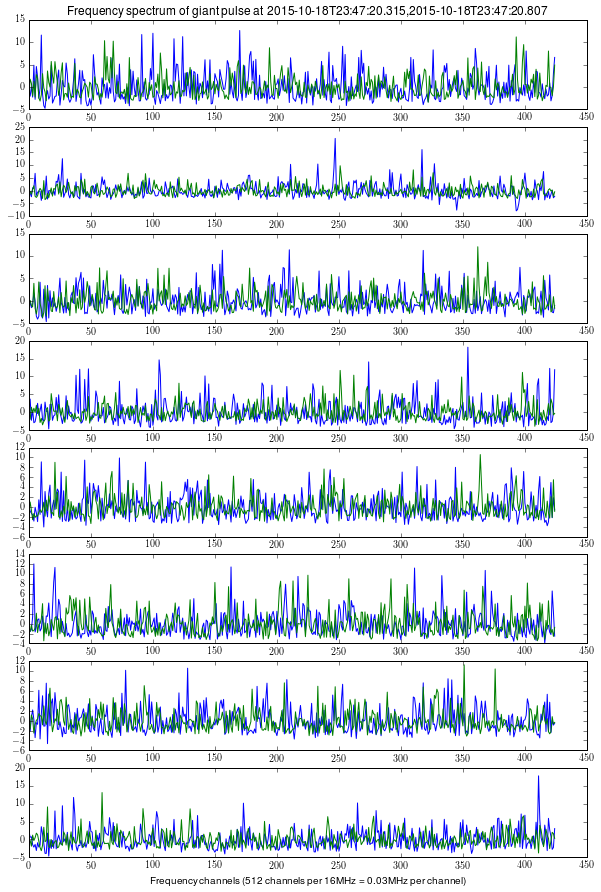

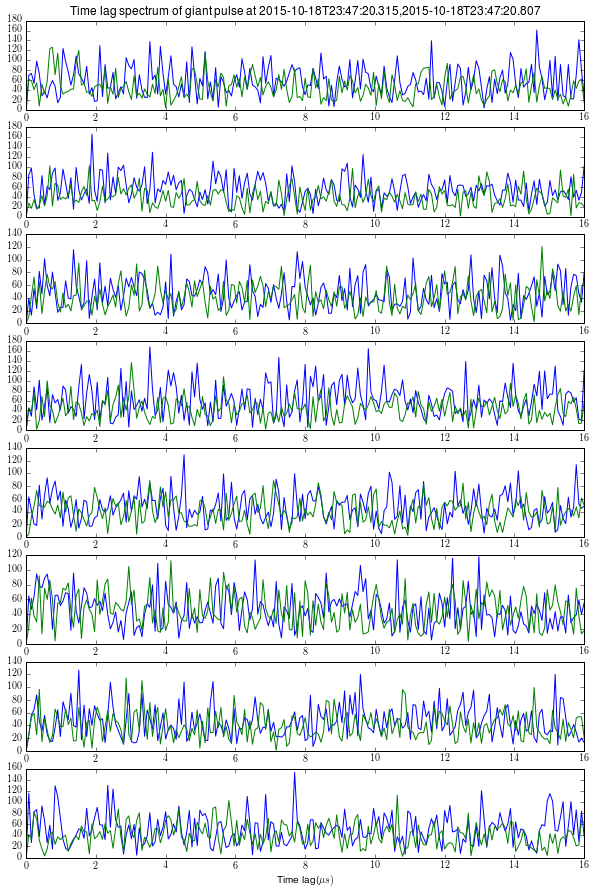

In [9]:
%pylab inline
i=34
j=35

fgp1=process_freq_spec(freq_values[i-1],i-1,draw=0)
tgp1=transform_to_timelag(fgp1,i)

fgp2=process_freq_spec(freq_values[j-1],j-1,draw=0)
tgp2=transform_to_timelag(fgp2,j)

plot_2_freq(fgp1,fgp2,[i-1,j-1])
plot_2_timelag(tgp1,tgp2,[i-1,j-1])


Function to compute the correlation coefficient

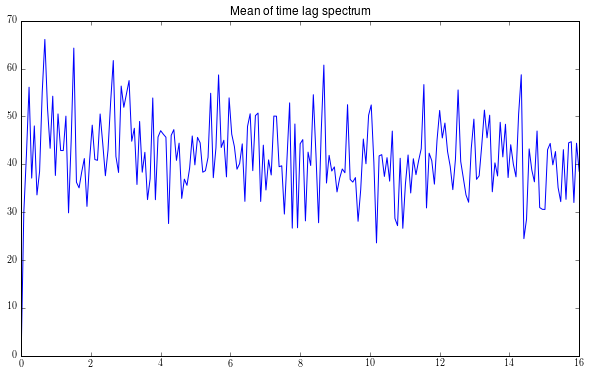

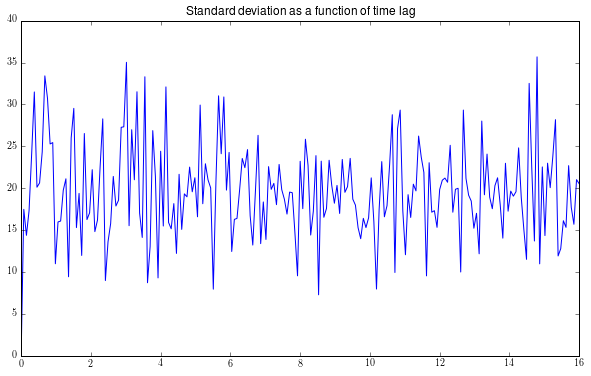

In [10]:
plotmean(tgp2)
find_std(tgp2)

In [ ]:
#load sigma noise 

def find_cc(i,j):
    fgp1=process_freq_spec(freq_values[i-1],i,draw=0) #-1 if getting i from .txt file. i only needed for plotting
    tgp1=transform_to_timelag(fgp1,i-1)
    fgp2=process_freq_spec(freq_values[j-1],j,draw=0)
    tgp2=transform_to_timelag(fgp2,j-1)
    
    tgp_avg1 = tgp1.mean(0)
    tgp_avg2 = np.conj(tgp2.mean(0))
    
    numerator = np.real(tgp_avg1*tgp_avg2)
    denominator = sqrt()
    
    
    
    

In [59]:
abs(tgp10).shape



(8, 213)